<a href="https://colab.research.google.com/github/mahmoudhaney/TrafficSignRecognition/blob/main/TrafficSignModel/TrafficSign_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Link Kaggle Dataset**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrarray22","key":"e4c1f648b359614117006aa0cb0b0a02"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 604M/612M [00:03<00:00, 159MB/s]
100% 612M/612M [00:03<00:00, 177MB/s]


In [ ]:
# Unzip dataset
! unzip gtsrb-german-traffic-sign.zip

# **2. Import Dependencies**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

# **3. Preparing & Preprocessing Images**

In [ ]:
dataset_dir = './'

folderMap = {
    0: '20 km/h', 1: '30 km/h', 2: '50 km/h', 3: '60 km/h', 4: '70 km/h', 5: '80 km/h', 6:'80 km/h end', 7: '100 km/h', 8: '120 km/h', 
    9: 'No overtaking', 10: 'No overtaking for tracks', 11: 'Crossroad with secondary way', 12: 'Main road', 13: 'Give way', 14: 'Stop', 
    15: 'Road up', 16: 'Road up for track', 17: 'Brock', 18: 'Other dangerous', 19: 'Turn left', 20: 'Turn right', 21: 'Winding road', 
    22: 'Hollow road', 23: 'Slippery road', 24: 'Narrowing road', 25: 'Roadwork', 26: 'Traffic light', 27: 'Pedestrian', 28: 'Children', 
    29: 'Bike', 30: 'Snow', 31: 'Deer', 32: 'End of the limits', 33: 'Only right', 34: 'Only left', 35: 'Only straight', 36: 'Only straight and right', 
    37: 'Only straight and left', 38: 'Take right', 39: 'Take left', 40: 'Circle crossroad', 41: 'End of overtaking limit', 42: 'End of overtaking limit for track'
}

In [ ]:
Meta = os.path.join(dataset_dir, 'Meta')
Train = os.path.join(dataset_dir, 'Train')

In [ ]:
num_classes = len(os.listdir(Train))
num_classes

43

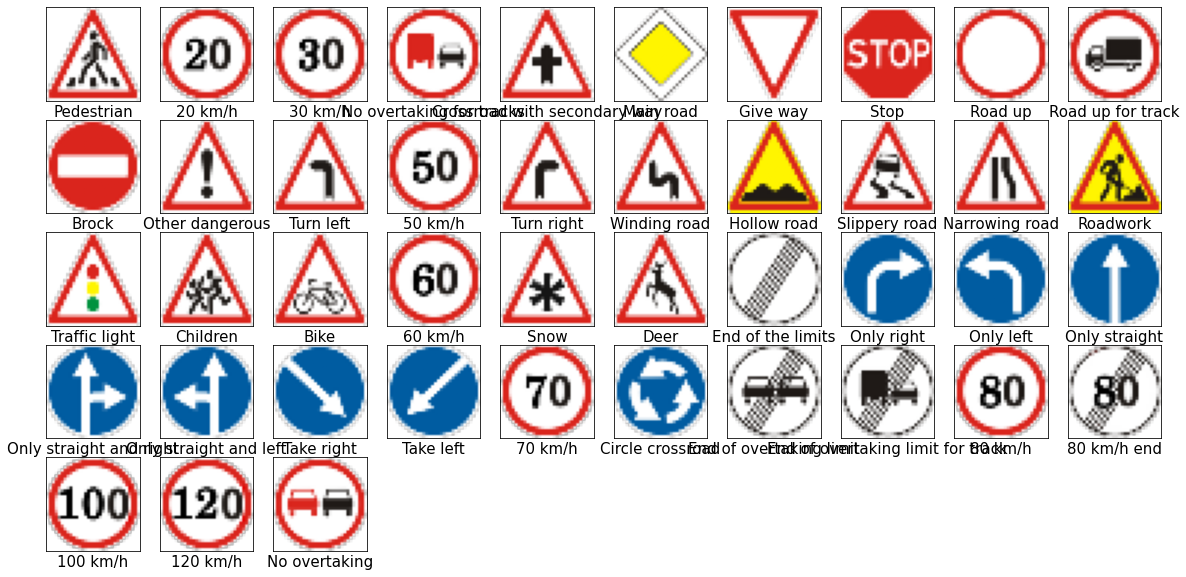

In [ ]:
df = pd.read_csv(os.path.join(dataset_dir, 'Meta.csv'))
df = df.sort_values(by=['ClassId'])

meta_images = []
meta_labels = []

for i in range(df.shape[0]):
    label = df.ClassId[i]
    image_path_meta = df.Path[i]
    image_path = os.path.join(dataset_dir, image_path_meta)
    image = plt.imread(image_path)
    image = cv2.resize(image, (32, 32))
    meta_images.append(image)
    meta_labels.append(folderMap[int(label)])

fig = plt.figure(figsize=(20, 10))
for i in range(len(meta_images)):
    ax = fig.add_subplot(5, 10, i+1)
    plt.axis()
    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel(xlabel = meta_labels[i], fontsize=15)
    ax.imshow(meta_images[i])

In [ ]:
images = []
labels = []
labels_idx = []

for label in os.listdir(Train):
    images_for_label = os.path.join(Train, label)
    for image in os.listdir(images_for_label):
        image = plt.imread(os.path.join(images_for_label, image))
        image = cv2.resize(image, (32, 32))
        images.append(image)
        labels.append(folderMap[int(label)])
        labels_idx.append(label)

In [ ]:
images = np.array(images)
labels = np.array(labels)
labels_idx = np.array(labels_idx, dtype='int32')

images.shape

(39209, 32, 32, 3)

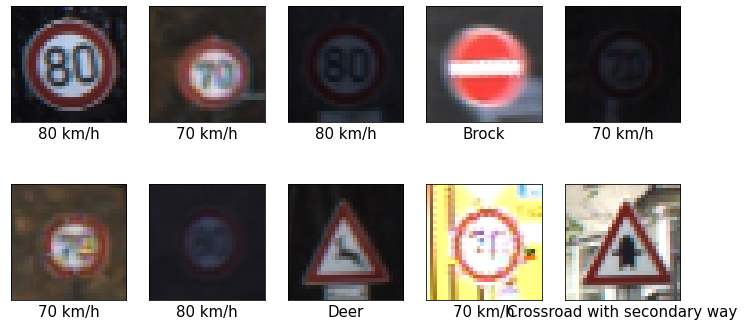

In [ ]:
fig = plt.figure(figsize=(12, 6))
for i in range(10):
    random_num = np.random.randint(0, 39209)
    ax = fig.add_subplot(2, 5, i+1)
    plt.axis()
    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel(xlabel = labels[random_num], fontsize=15)
    ax.imshow(images[random_num])

# **4. Splitting Sataset**

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(images, labels_idx, random_state=1, stratify=labels_idx, shuffle=True,test_size=0.2)

In [ ]:
print("Training: ", len(X_train_svm))
print("Testing : ", len(X_test_svm))

Training:  31367
Testing :  7842


## Data Distribution

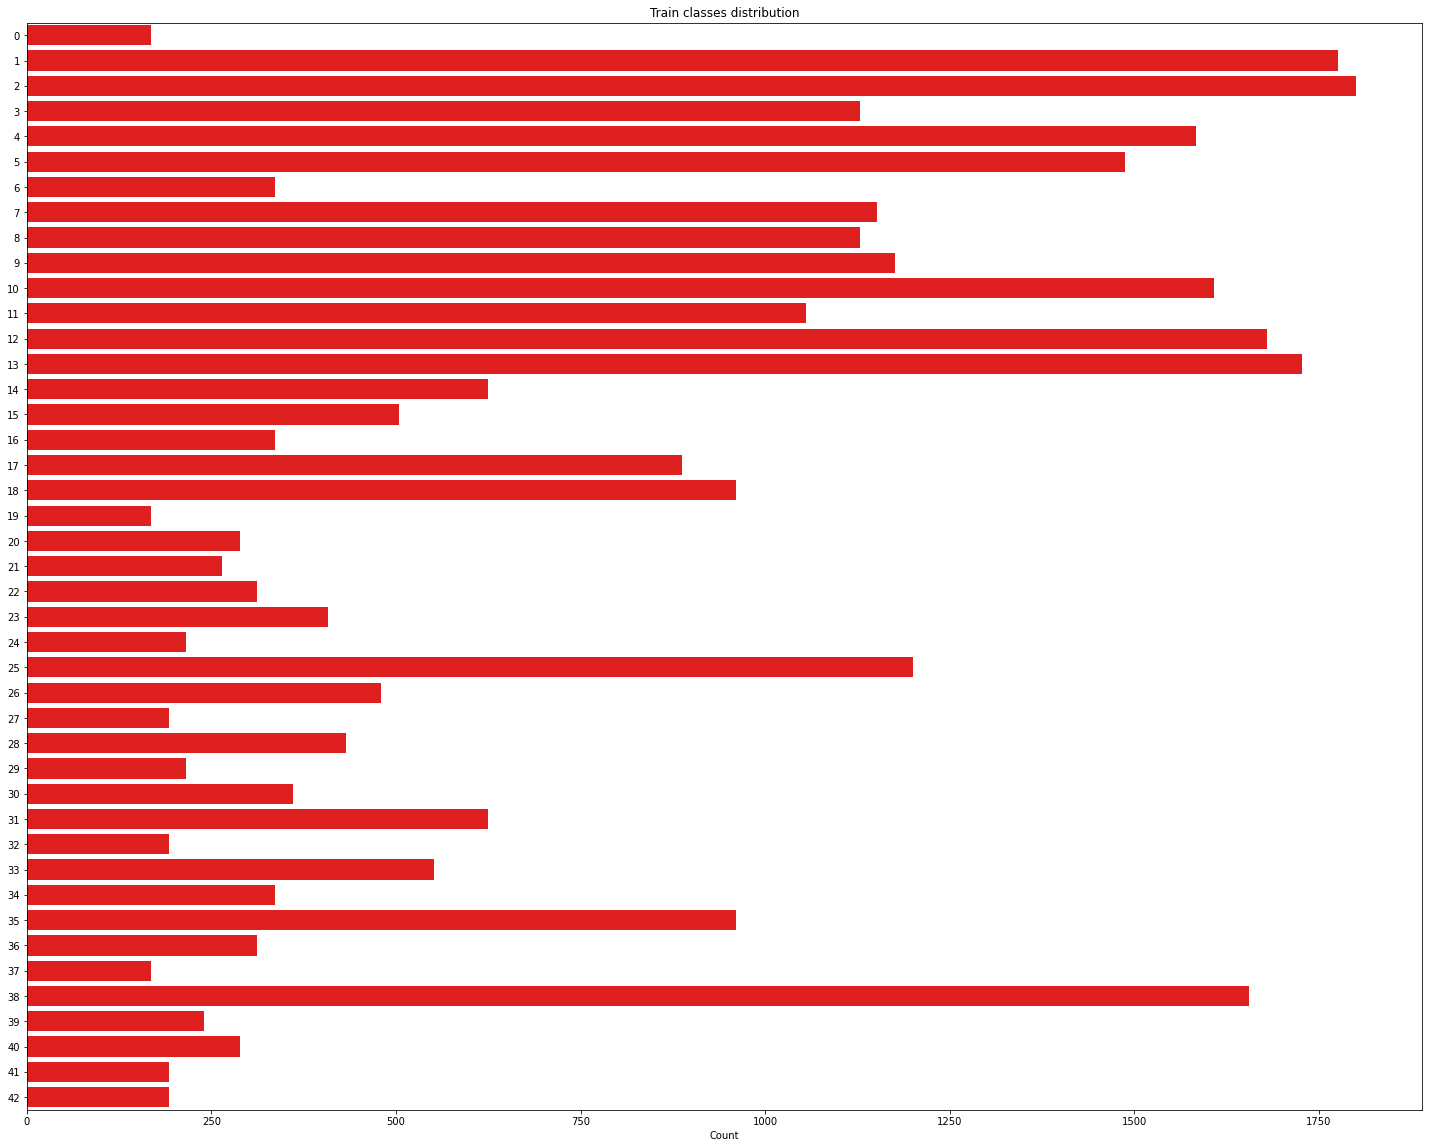

In [ ]:

plt.figure(figsize=(25, 20))
plt.title('Train classes distribution')
sns.countplot(y=y_train_svm, color="red")
plt.xlabel('Count')
plt.show()

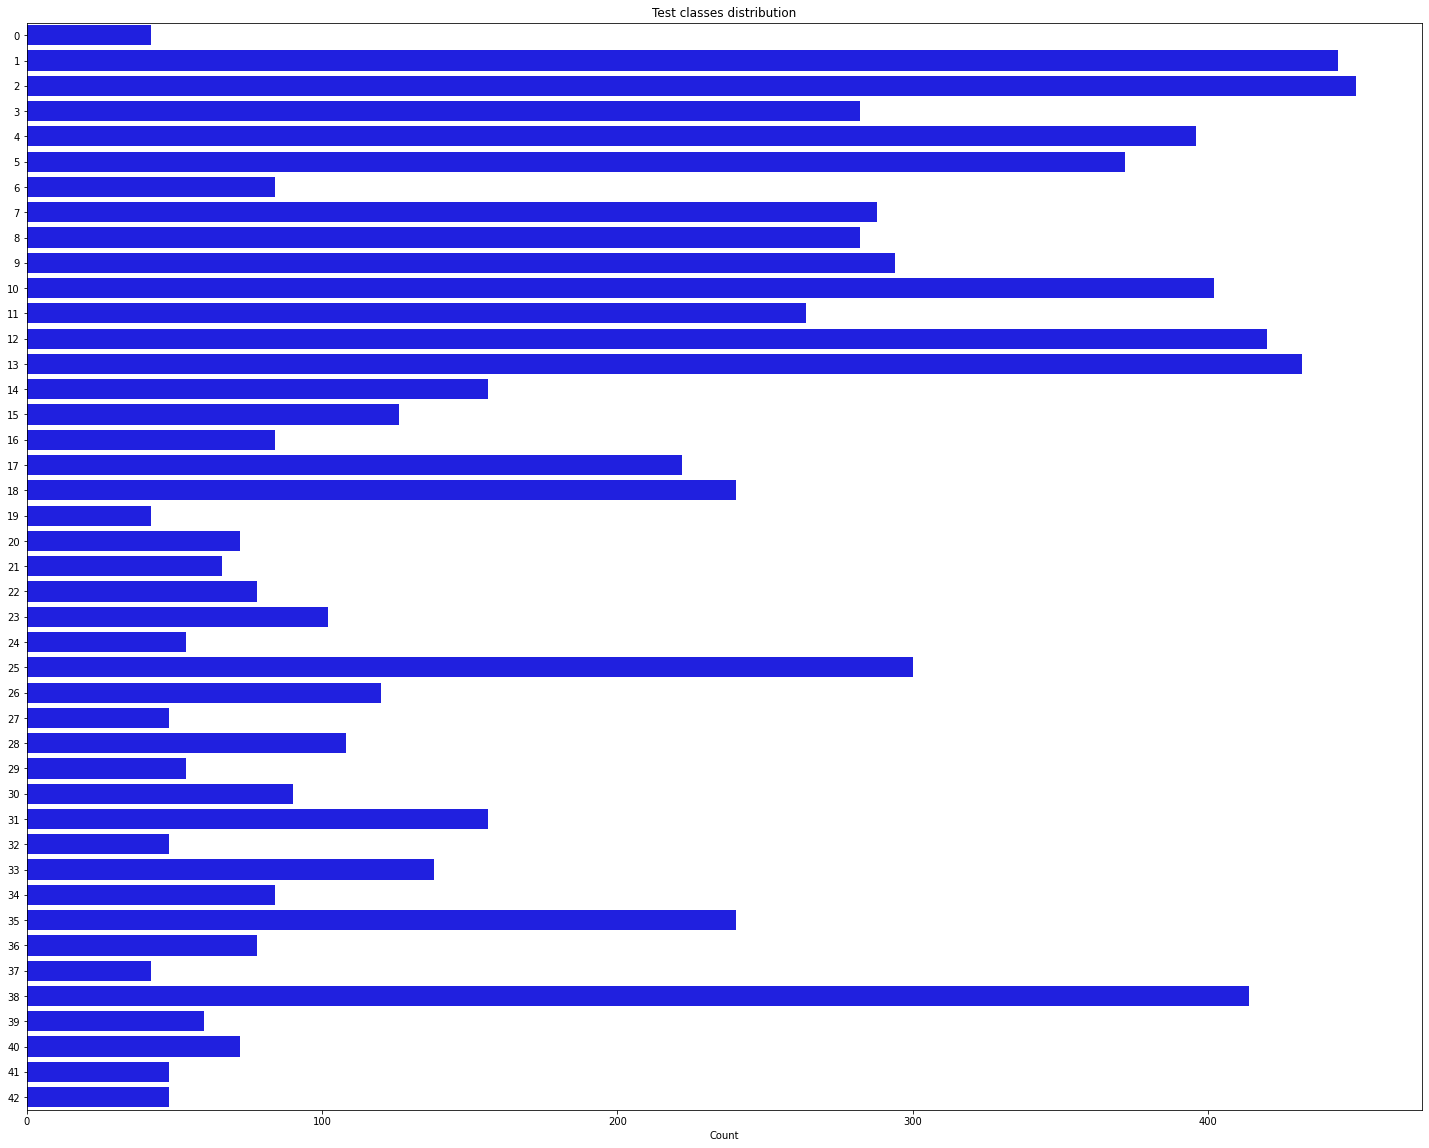

In [ ]:
plt.figure(figsize=(25, 20))
plt.title('Test classes distribution')

sns.countplot(y=y_test_svm, color="blue")
plt.xlabel('Count')
plt.show()

# **5. Training & Evaluation**

In [ ]:
from sklearn.svm import SVC
import pickle
from sklearn.metrics import accuracy_score

In [ ]:
# Reshapping Data
nsamples=39209
nx=32
ny=32
f=3
# Training
nsamples, nx, ny,f = X_train_svm.shape
dx_train_dataset = X_train_svm.reshape((nsamples,nx*ny,f))
dx_train_dataset = X_train_svm.reshape((nsamples,nx*ny*f))
# Testing
nsamples, nx, ny,f = X_test_svm.shape
dx_test_dataset = X_test_svm.reshape((nsamples,nx*ny,f))
dx_test_dataset = X_test_svm.reshape((nsamples,nx*ny*f))

In [ ]:
# Training The Model Using SVM
model = SVC(kernel='linear')
model.fit(dx_train_dataset, y_train_svm)
pick = open('medol.sav','wb')
pickle.dump(model, pick)
pick = open('medol.sav','rb')
model = pickle.load(pick)
pick.close()

In [ ]:
# Accuracy Score of Training Data
accuracy = model.score(dx_train_dataset,y_train_svm)
print("Training Accuracy -> ", accuracy*100)

Training Accuracy ->  99.95536710555679


In [ ]:
# Accuracy Score of Testing Data
accuracy = model.score(dx_test_dataset,y_test_svm)
print("Testing  Accuracy -> ", accuracy*100)

Testing  Accuracy ->  95.70262688089774


### Another Way For Accuracy

In [ ]:
# Accuracy Score of Training Data
x_test_predict = model.predict(dx_train_dataset)
test_data_accuracy = accuracy_score(y_train_svm, x_test_predict)
print("Accuracy for training -> ", test_data_accuracy*100)

Accuracy for training ->  99.95536710555679


In [ ]:
# Accuracy Score of Testing Data
x_test_predict = model.predict(dx_test_dataset)
test_data_accuracy = accuracy_score(y_test_svm, x_test_predict)
print("Accuracy for  testing -> ", test_data_accuracy*100)

Accuracy for  testing ->  95.70262688089774


In [ ]:
import numpy as np
import pandas as pd
from sklearn import model_selection, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [ ]:
def NeuralClass(X,y):
    X_train,X_test,y_train,y_test = model_selection.train_test_split(
        X,y,test_size=0.2)
    mlp=MLPClassifier(
        activation="relu",
        max_iter=3000, 
        validation_fraction=0.2, 
        early_stopping=True)
    mlp.fit(X_train,y_train)
    print (mlp.score(X_train,y_train))
    plt.plot(mlp.loss_curve_)
    plt.plot(mlp.validation_scores_)

0.9734587335113378


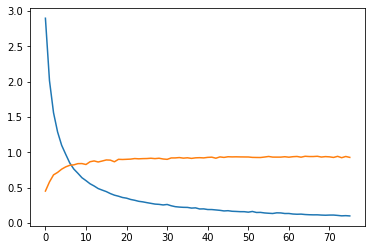

In [ ]:
NeuralClass(dx_train_dataset,y_train_svm)

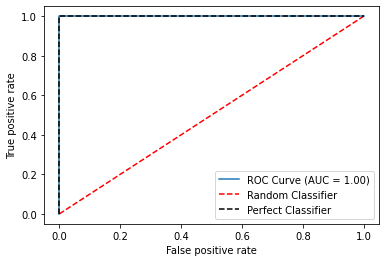

In [ ]:
from sklearn.metrics import roc_curve,auc
fpr_sum = np.zeros(3)
tpr_sum = np.zeros(3)
for class_num in range(43):
  predications = []
  true_labels = []
  for i in range(x_test_predict.shape[0]):
    if(x_test_predict[i] == class_num):
      predications.append(1)
    else:
      predications.append(0)

    if(x_test_predict[i] == class_num):
      true_labels.append(1)
    else:
      true_labels.append(0)

  predications = np.array(predications)
  true_labels = np.array(true_labels)
  fpr,tpr,_ = roc_curve(true_labels,predications)
  fpr_sum += fpr
  tpr_sum += tpr


fpr = fpr_sum / 43
tpr = tpr_sum / 43

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')   
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', color='black', label='Perfect Classifier')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.show()
